In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [2]:
import pandas as pd 
import numpy as np 
from collections import Counter 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re

import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.corpus import stopwords

from wordcloud import WordCloud 

from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import string

from textblob import TextBlob

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
## Caricamento dataset

data = pd.read_csv("C:/Users/cafe6/Documents/GitHub/Reviews.csv")

#data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/TextMiningProject/Reviews.csv")

# Data cleaning & exploration 

### Descrizione del dataset

In [4]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
data.shape

(568454, 10)

In [6]:
print(len(data['ProductId'].unique()))
print(len(data['UserId'].unique()))

74258
256059


Abbiamo 568454 review totali, in particolare riferite a 74258 prodotti unici e appartenenti a 256059 utenti unici.

In [7]:
print(data['HelpfulnessNumerator'].describe())
print(data['HelpfulnessDenominator'].describe())

count    568454.000000
mean          1.743817
std           7.636513
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         866.000000
Name: HelpfulnessNumerator, dtype: float64
count    568454.00000
mean          2.22881
std           8.28974
min           0.00000
25%           0.00000
50%           1.00000
75%           2.00000
max         923.00000
Name: HelpfulnessDenominator, dtype: float64


HelpfulnessNumerator ed HelpfulnessDenominator sono, rispettivamente, il numero di utenti che hanno ritenuto la review utile ed il numero totale di utenti che hanno espresso un parere sulla review.

Per come sono definite, si deve sempre avere HelpfulnessNumerator <= HelpfulnessDenominator. Eseguo un controllo a riguardo:

In [8]:
data[data['HelpfulnessNumerator'] > data['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


Ci sono due review che non soddisfano questo requisito, vado ad eliminarle dal dataset:

In [9]:
# Rimozione inconsistenza HelpfulnessDenominator e HelpfulnessNumerator

data_clean = data[data['HelpfulnessNumerator'] <= data['HelpfulnessDenominator']]
print(data_clean.shape)

(568452, 10)


In [10]:
# Potrebbe essere interessante valutare quante persone hanno trovato utile una review

data_clean['HelpfulnessRatio'] = data_clean['HelpfulnessNumerator']/data_clean['HelpfulnessDenominator']
data_clean["HelpfulnessRatio"] = pd.to_numeric(data_clean["HelpfulnessRatio"])

In [11]:
print(data['Score'].describe())

count    568454.000000
mean          4.183199
std           1.310436
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64


I valori di Score sono compresi nell'intervallo [1,5], con una media di 4.18.

### Data cleaning

- Missing values
- Duplicati

In [12]:
# Check missing values
data_clean.isnull().sum()

Id                             0
ProductId                      0
UserId                         0
ProfileName                   16
HelpfulnessNumerator           0
HelpfulnessDenominator         0
Score                          0
Time                           0
Summary                       27
Text                           0
HelpfulnessRatio          270052
dtype: int64

In [13]:
# Estraggo gli UserId corrispondenti alle righe con "ProfileName" mancante

missing_names = list(data_clean[data_clean['ProfileName'].isnull()]['UserId'])

In [14]:
[i for i in missing_names if i in data_clean['UserId']]

[]

Ho controllato se gli UserId corrispondenti agli utenti con nome mancante fossero presenti nel dataset per altre review, in modo da (eventualmente) estrarre il nome corrispondente dell'utente. Questo non si verifica.
In ogni caso, il nome utente non è così importante, quindi non si eliminano questi record.

In [15]:
# Missing values per Summary

data_clean[data_clean['Summary'].isnull()].head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio
33958,33959,B00412W76S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...,0.041667
40548,40549,B00020HHRW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...,0.041667
101106,101107,B0014B0HWK,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...,0.041667
102979,102980,B000FVDWU4,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...,0.041667
117515,117516,B0016B7Z32,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...,0.041667


Noto che buona parte di questi record sembrano essere dei duplicati. In generale, comunque, la mancanza della Summary non è particolarmente importante, quindi non elimino nemmeno questi record.

In [16]:
# Check duplicati


data_clean.duplicated(subset = ["UserId","ProfileName","Time","Text"]).sum()

174521

Ci sono 174521 review dello stesso utente, nello stesso momento e con lo stesso identico commento. Procedo ad eliminare i duplicati:

In [17]:
df = data_clean.drop_duplicates(subset = ["UserId","ProfileName","Time","Text"])

In [18]:
print(df.shape)
print(100-df.shape[0]/data.shape[0]*100)

(393931, 11)
30.701340829688945


Sono state eliminate quasi 170000 review (circa il 30% di quelle iniziali).

In [19]:
# Sistemo il formato di "Time"

df["Time"] = pd.to_datetime(df.Time,  unit='s')

In [20]:
# Sostituisco i missing values di ProfileName e Summary con delle stringhe vuote. Non faccio nulla per HelpfulnessRatio per ora

df["ProfileName"] = df["ProfileName"].fillna('')
df["Summary"] = df["Summary"].fillna('')

### Esplorazione

- Distribuzione Score
- Score vs. HelpfulnessRatio / Score vs. Numero di parole
- N° Reviews vs. HelpfulnessRatio / N° Reviews vs. Year
- WordCloud

In [21]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,NaN


Text(0, 0.5, 'Number of reviews')

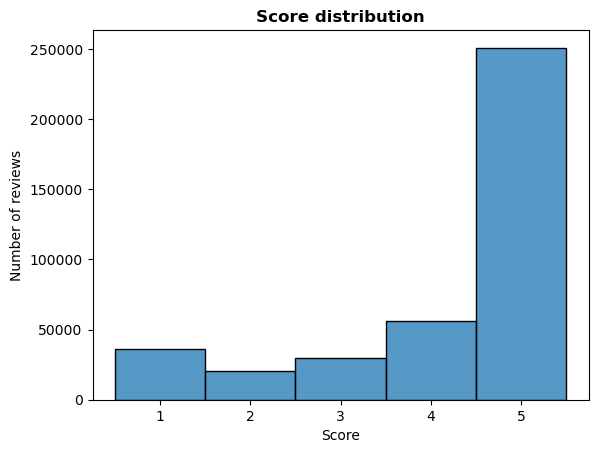

In [22]:
# Distribuzione voti

sns.histplot(df['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [23]:
print(df['Score'].value_counts());
print(df['Score'].value_counts()/len(df['Score']));

5    250961
4     56093
1     36306
3     29769
2     20802
Name: Score, dtype: int64
5    0.637068
4    0.142393
1    0.092163
3    0.075569
2    0.052806
Name: Score, dtype: float64


Potrebbe essere interessante valutare la distribuzione condizionata di Score rispetto ad altre variabili. In particolare, potrebbe essere interessante valutare rispetto al numero di parole per review e all'HelpfulnessRatio

Text(0, 0.5, 'HelpfulnessRatio')

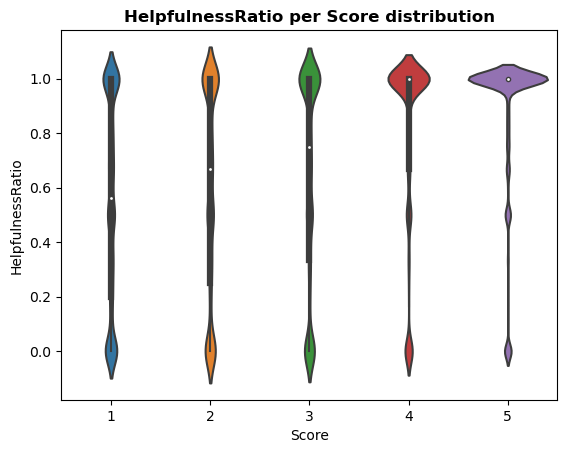

In [24]:
sns.violinplot(df, x="Score", y="HelpfulnessRatio")
plt.title("HelpfulnessRatio per Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("HelpfulnessRatio")

In [25]:
# Creo la variabile "WordCount" per il numero di parole per review

df["WordCount"] = df["Text"].apply(lambda x: len(x.split()))

Text(0, 0.5, 'WordCount')

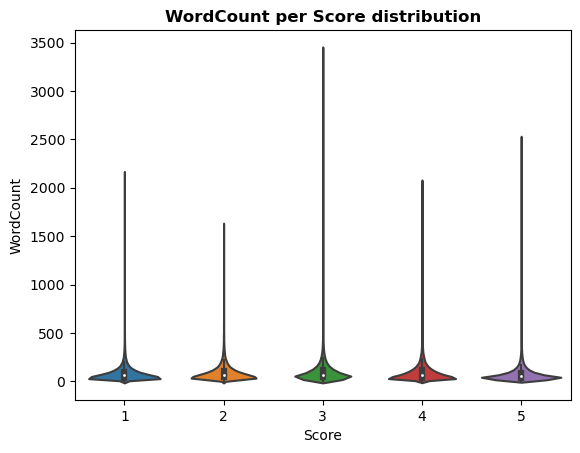

In [26]:
sns.violinplot(df, x="Score", y="WordCount")
plt.title("WordCount per Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("WordCount")

Text(0, 0.5, 'WordCount')

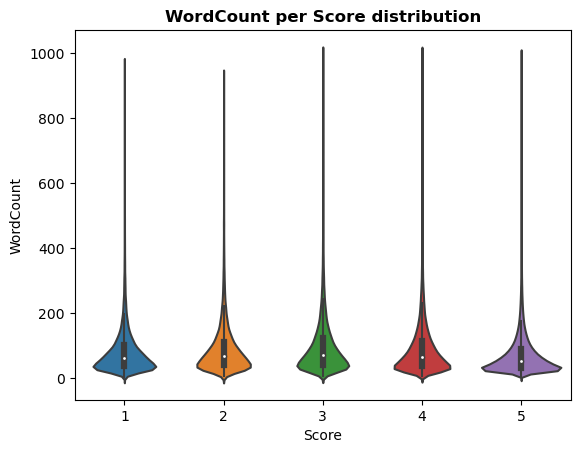

In [27]:
sns.violinplot(df[df['WordCount']<1000], x="Score", y="WordCount")
plt.title("WordCount per Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("WordCount")

Text(0.5, 1.0, 'Reviews per year distribution')

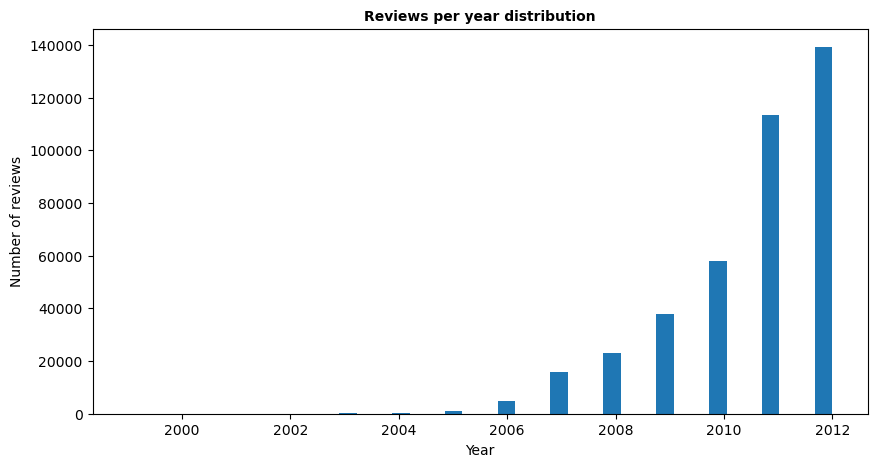

In [28]:
plt.figure(figsize=(10,5))
plt.hist(df["Time"].dt.year, bins=40)
plt.ylabel('Number of reviews')
plt.xlabel('Year')
plt.title('Reviews per year distribution', fontweight='bold', fontsize=10)

Text(0.5, 1.0, 'Reviews per Helpfulness Ratio')

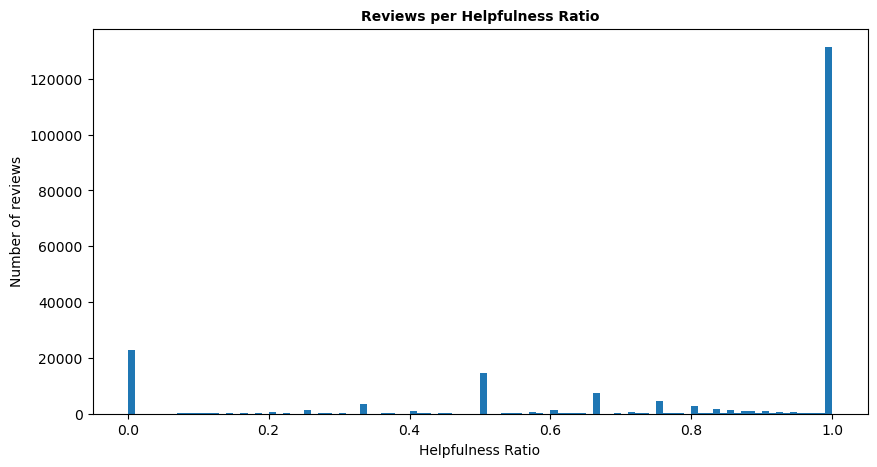

In [29]:
df_help = df[df["HelpfulnessRatio"].notnull()]

plt.figure(figsize=(10,5))
plt.hist(df_help['HelpfulnessRatio'], bins = 100)
plt.ylabel('Number of reviews')
plt.xlabel('Helpfulness Ratio')
plt.title('Reviews per Helpfulness Ratio', fontweight='bold', fontsize=10)

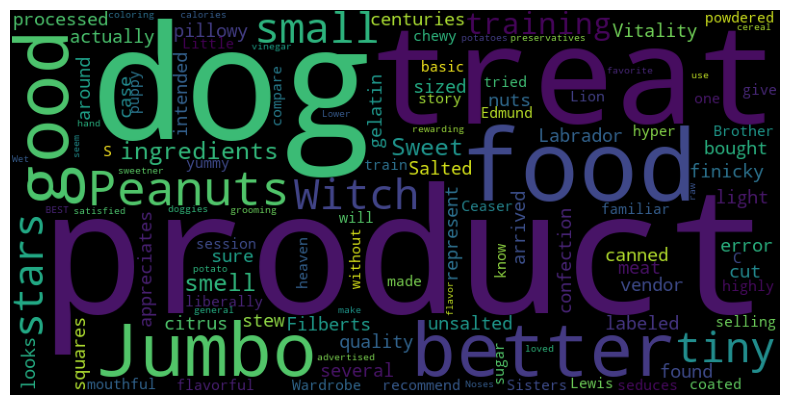

In [30]:
text_values = df['Text'].values 

wordcloud = WordCloud(width=800, height=400, collocations=False).generate(str(text_values))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Preprocessing

### Normalizzazione 

- Lower case - OK
- Rimozione caratteri duplicati e correzione spelling - OK
- Rimozione numeri - OK
- Rimozione emoji - OK
- Rimozione URL e tag HTML - OK
- Rimozione punteggiatura e caratteri speciali - OK
- Espansione forme contratte (?) --> potrebbe aiutare in termini di rimozione delle stopwords

- Rimozione commenti non in lingua inglese (?) --> il un paper che ho trovato viene fatto

In [31]:
def text_to_lower(phrase):
    phrase = phrase.lower()
    return phrase

# Ref: "https://gist.github.com/n1n9-jp/5857d7725f3b14cbc8ec3e878e4307ce" - "http://www.unicode.org/charts/"
# Se ci accorgiamo di altre emoji basta aggiungere il codice corrispondente

def rm_emojis(phrase):
    emoj = re.compile("["
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U00002600-\U000026FF"  # Miscellaneous Symbols
        u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                      "]+", re.UNICODE)
    return re.sub(emoj, '', phrase)

def rm_url(phrase):
    remove_https = re.sub(r'http\S+', '', phrase)
    remove_com = re.sub(r"www.[A-Za-z]*\.com", " ", remove_https)
    return remove_com

def rm_html_tags(phrase):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', phrase)

def rm_repeated_char(phrase):
    pattern = re.compile(r"([A-Za-z])\1{2,}", re.DOTALL)
    clean_text = pattern.sub(r"\1\1", phrase) 
    return clean_text

def spelling_correction(phrase):
    textBlb = TextBlob(phrase)        
    textCorrected = textBlb.correct()
    textCorrected = str(textCorrected)
    return textCorrected

def rm_numbers(phrase):
    phrase_no_num = re.sub(r'\d+', '', phrase)
    return phrase_no_num

def rm_punct_symb(phrase):
    phrase_no_punct = "".join([i for i in phrase if i not in string.punctuation])
    return phrase_no_punct

In [32]:
def normalization(phrase):
    output = text_to_lower(phrase)
    output = rm_emojis(output)
    output = rm_url(output)
    output = rm_html_tags(output)
    output = rm_repeated_char(output)
    output = spelling_correction(output)
    output = rm_numbers(output)
    output = rm_punct_symb(output)
    return output

In [33]:
df.shape

(393931, 12)

In [34]:
# Splitto il dataset

df_1 = df.iloc[:39000,:]
df_2 = df.iloc[39000:78000,:]
df_3 = df.iloc[78000:117000,:]
df_4 = df.iloc[117000:156000,:]
df_5 = df.iloc[156000:195000,:]
df_6 = df.iloc[195000:234000,:]
df_7 = df.iloc[234000:273000,:]
df_8 = df.iloc[273000:312000,:]
df_9 = df.iloc[312000:351000,:]
df_10 = df.iloc[351000:,:]

In [35]:
# Applico normalizzazione ai vari subset per evitare di perdere pezzi per strada (il processamento è piuttosto lungo)

#df1_normalized = df_1
#df1_normalized['Normalized Text'] = df_1['Text'].apply(normalization)
#df1_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df1_normalized.csv')

#print('Done')

#df2_normalized = df_2
#df2_normalized['Normalized Text'] = df_2['Text'].apply(normalization)
#df2_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df2_normalized.csv')

#print('Done')

#df3_normalized = df_3
#df3_normalized['Normalized Text'] = df_3['Text'].apply(normalization)
#df3_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df3_normalized.csv')

#print('Done')

#df4_normalized = df_4
#df4_normalized['Normalized Text'] = df_4['Text'].apply(normalization)
#df4_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df4_normalized.csv')

#print('Done')

#df5_normalized = df_5
#df5_normalized['Normalized Text'] = df_5['Text'].apply(normalization)
#df5_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df5_normalized.csv')

#print('Done')

#df6_normalized = df_6
#df6_normalized['Normalized Text'] = df_6['Text'].apply(normalization)
#df6_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df6_normalized.csv')

#print('Done')

#df7_normalized = df_7
#df7_normalized['Normalized Text'] = df_7['Text'].apply(normalization)
#df7_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df7_normalized.csv')

#print('Done')

#df8_normalized = df_8
#df8_normalized['Normalized Text'] = df_8['Text'].apply(normalization)
#df8_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df8_normalized.csv')

#print('Done')

#df9_normalized = df_9
#df9_normalized['Normalized Text'] = df_9['Text'].apply(normalization)
#df9_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df9_normalized.csv')

#print('Done')

#df10_normalized = df_10
#df10_normalized['Normalized Text'] = df_10['Text'].apply(normalization)
#df10_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df10_normalized.csv')

Done
Done
Done


In [37]:
df1_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df1_normalized.csv')
df2_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df2_normalized.csv')
df3_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df3_normalized.csv')
df4_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df4_normalized.csv')
df5_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df5_normalized.csv')
df6_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df6_normalized.csv')
df7_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df7_normalized.csv')
df8_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df8_normalized.csv')
df9_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df9_normalized.csv')
df10_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df10_normalized.csv')

In [45]:
# Dataset normalizzato completo

df_normalized = pd.concat([df1_normalized, df2_normalized, df3_normalized, df4_normalized, df5_normalized, df6_normalized, df7_normalized, df8_normalized, df9_normalized, df10_normalized])
df_normalized.drop('Unnamed: 0', axis = 1, inplace=True)
df_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_normalized_complete.csv')

### Tokenizzazione (ricorda di usare strip per rimuovere spazi extra)

In [50]:
df_normalized[df_normalized['Normalized Text'].isna()]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio,WordCount,Normalized Text
5575,93596,B004IJMVQK,A1FJTIEV5LJYJE,David Crenshaw,3,4,5,2008-03-08,Great Buy!!! By buying in bulk and auto-ship ...,"<a href=""http://www.amazon.com/gp/product/B000...",0.750000,15,NaN
11760,101733,B002WD93EW,AR1AKOSLSZ3K9,"Kindredspirit0806 ""DEB""",1,3,5,2010-09-10,Starbucks T-discs,"<a href=""http://www.amazon.com/gp/product/B002...",0.333333,17,NaN
26835,346480,B001CHH3QY,A3QZZ2NRCC41D6,D. Sandvick,0,1,5,2009-06-14,producte review,"<a href=""http://www.amazon.com/gp/product/B001...",0.000000,17,NaN
7548,446364,B000LKZTR8,A1ZPHPEOCVIRCH,"LEE A. ""lmcc@charter.net""",1,7,4,2007-11-24,WORKS AS PROMISED,"<a href=""http://www.amazon.com/gp/product/B000...",0.142857,15,NaN


Ci sono dei problemi in fase di normalizzazione con la rimozione dei tags. Non capisco dove sia il problema, visto che applicando una alla volta le funzioni dentro la normalizzazione non ci sono problemi. In ogni caso, il testo della review in quei casi è (controllato manualmente) dato esclusivamente dal nome del prodotto. Rimuovo quelle righe e procedo alla tokenizzazione.

In [76]:
df_normalized = df_normalized[df_normalized['Normalized Text'].notna()]

In [78]:
df_tokenized = df_normalized
df_tokenized['Tokenized Text'] = df_normalized['Normalized Text'].apply(word_tokenize)

In [ ]:
df_tokenized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_tokenized_complete.csv')

### Rimozione stop-words

Rimuovo anche eventuali parole di una sola lettera non presenti nella lista delle stop words

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')

def stopwords_removal(text, stopwords):
    return ([word for word in text if ((word not in stop_words) and (len(word) > 1))])

In [ ]:
df_no_stop_words = df_tokenized
df_no_stop_words['Text_No_Stop_Words'] = df_tokenized['Tokenized Text'].apply(lambda x: stopwords_removal(x, stop_words))

In [ ]:
df_no_stop_words['Text_No_Stop_Words'][0]

### Lemmatization/Stemming

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
def lemmatizer(tokens):
    lemmas = []
    for word in tokens:
        lemmas.append(wordnet_lemmatizer.lemmatize(word))
    return lemmas

In [ ]:
df_lemmatized = df_no_stop_words
df_lemmatized['Lemmatized Text'] = df_no_stop_words['Text_No_Stop_Words'].apply(lemmatizer)

In [ ]:
df_lemmatized['Lemmatized Text'][0]